# Декомпозиция задачи

**Заказчик**: менеджер по товарному ассортименту.

**Задача**: провести категоризацию товаров и определить основные и дополнительные товары.

**Желаемый результат**: по итогам исследования нужно подготовить презентацию с выводами и инсайтами и дашборд.

**Описание данных**:
 
Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут».

Колонки датасета:
- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара (за штуку).

**План работы**:
1. Выгрузка данных;
2. Предобработка данных:
3. Исследовательский анализ данных;
4. Проверка гипотезы: средняя выручка в основных категориях выше, чем в дополнительных
5. Общие выводы.


# Выгрузка данных

Для начала импортируем все нужные библиотеки:

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import requests
import scipy.stats as st
import plotly.io as pio
import warnings

from bs4 import BeautifulSoup
from itertools import chain
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')
pio.renderers.default='jpeg'

Напишем функцию, для вывода красивых графиков:

In [2]:
# функция для настройки стиля в графиках
def style_plot(
    xlabel='',
    ylabel='',
    title='',
    yticks=True  
):
    
    fig.update_layout(
        autosize=True,
        xaxis_title_text=xlabel,
        yaxis_title_text=ylabel,
        plot_bgcolor='white',
        xaxis=dict(
            showline=True,
            linecolor='#58595B',
            color='black',
            categoryorder='total descending'
        ),
        yaxis=dict(
            color='black',
            showgrid=True,
            gridcolor='#E6E7E8',
            showticklabels=yticks
        ),
        title=dict(
            text=title,
            font=dict(
                color='black'
            )
        )
    )

# цвета для графиков
colors = ['#' +i for i in ["264653","2a9d8f","e9c46a","f4a261","e76f51"]]
colors_rgba = ['rgba(38, 70, 83, 0.5)', 'rgba(42, 157, 143, 0.5)', 'rgba(233, 196, 106, 0.5)', 'rgba(244, 162, 97, 0.5)', 'rgba(231, 111, 81, 0.5)']

In [3]:
# выгружаем данные
data = pd.read_csv('datasets/ecommerce_dataset.csv')

Посмотрим на данные: выведем первые строчки, общую информацию и описательные статистики.

In [4]:
# выведем первые 5 строк датасета
data.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [5]:
# выведем общую информацию по датасету
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


На первый взгляд в данных нет пропусков и все типы данных, кроме даты, правильные.

In [6]:
# выведем описательные статистики
data.describe().round(2)

,date,order_id,quantity,price
count,6.737000e+03,6737.00,6737.00,6737.00
mean,2.018855e+09,43128.95,2.50,462.03
std,3.855185e+05,27899.41,15.27,871.30
min,2.018100e+09,12624.00,1.00,9.00
25%,2.019020e+09,14827.00,1.00,101.00
50%,2.019050e+09,68503.00,1.00,135.00
75%,2.019061e+09,70504.00,1.00,398.00
max,2.019103e+09,73164.00,1000.00,14917.00


Данные выгружены, первый взгляд брошен. Теперь можно заняться предобработкой.

# Предобработка данных

При выгрузке данных мы увидели что у нас отсутствуют пропуски, но мы увидели, что есть неправильные типы данных, также нужно проверить данные на дубликаты. Ну и в завершении сделаем несколько новых фич: общую стоимость продукта и категорию продукта. 

На стадии предобработки данных, мы будем резать исходный датасет. Чтобы оценить насколько мы урезали изначальные данные сохраним переменную с сырым датасетом:

In [7]:
# создадим переменную с сырыми данными
raw_data = data.copy()

## Исправление типов данных

Из первого взгляда на данные мы увидели проблему с датами. В дате "слиплись": год, месяц, день, час. Приведем к правильному формату даты:

In [8]:
# исправляем формат дат
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H')

Проверим результат:

In [9]:
# выведем первые 5 строк столбца с датами
data['date'].head()

0   2018-10-01
1   2018-10-01
2   2018-10-01
3   2018-10-01
4   2018-10-01
Name: date, dtype: datetime64[ns]

Формат правильный. Часы тут не видны потому что в первых строках они равны "00" и pandas их сокращает. Проведем сортировку по дате:

In [10]:
data = data.sort_values(by='date')

## Проверка дубликатов

Посмотрим, есть ли в данных явные дубликаты:

In [11]:
# выведем количество явных дубликатов
print('Количество явных дубликатов:', data.duplicated().sum())

Количество явных дубликатов: 0


На первый взгляд явных дубликатов нет. Посмотрим, есть ли дублирование заказов. Дублированный заказ – это заказ в котором все параметры одинаковые, кроме номера заказа.

In [12]:
print('Количество дублированных заказов:', data.drop('order_id', axis=1).duplicated().sum())

Количество дублированных заказов: 18


В нашем датасете 18 раз встречаются дублированные заказы. Удалим такие дубликаты:

In [13]:
# убираем дублированные заказы
data = data.drop(index=data[data.drop('order_id', axis=1).duplicated()].index)

# проверяем удаление
print('Количество дублированных заказов:', data.drop('order_id', axis=1).duplicated().sum())

Количество дублированных заказов: 0


Продолжим поиск аномалий в заказах.

Во-первых, узнаем, что означает дата заказ: момент оформления заказа или момент добавления товара в корзину? Как это проверить? Посмотрим сколько уникальных дат соответствуют одному заказу. Если каждому заказу соответствует одна дата, то это момент оформления или оплаты заказа. А вот если уникальных дат несколько, то это момент добавления товара в корзину.

In [14]:
# посмотрим сколько дат соответствуют заказам в процентах
order_dates = data.pivot_table(
    index='order_id',
    values='date',
    aggfunc=['nunique', 'first', 'last']
)

# переименуем столбцы
order_dates.columns=['unique_dates', 'first_date', 'last_date']

# выведем долю количества дней
(order_dates['unique_dates'].value_counts() / data['order_id'].nunique()).head()

1    0.897760
2    0.067919
3    0.019147
4    0.006142
5    0.002890
Name: unique_dates, dtype: float64

Большинство заказов имеют лишь 1 уникальную дату. Но что может означать 2 и более дат? Например, что это дата добавления товара в корзину. Соответственно разница между первой датой и последней – это срок формирования заказа. Как найти здесь аномалии? Предположим, что для магазина товаров для дома и дачи нормально, если пользователь формирует свой заказ до 7 дней. А все, что выходит за эти рамки это аномалии. Посмотрим, сколько у нас заказов с аномалиями, и если это не критическое значение, то удалим их.

In [15]:
# найдем долю аномально долгого оформления заказа
order_dates['timedelta'] = (order_dates['last_date'] - order_dates['first_date']).dt.days
print(
    'Доля заказов со сроком оформления более 7 дней: {:.2%}'
    .format(len(order_dates.query('timedelta > 7')) /  len(order_dates))
)

Доля заказов со сроком оформления более 7 дней: 1.37%


Всего лишь 1,4% заказов имеют срок оформления более 7 дней. Примем такие заказы за аномалии и очистим данные от них:

In [16]:
# делаем срез данных
data = data[data['order_id'].isin(order_dates.query('timedelta < 8').index)]

In [17]:
# сколько уникальных дат соответствуют заказам
data.groupby('order_id')['date'].nunique().value_counts()

1     2485
2      172
3       46
4       14
5        7
7        3
6        1
10       1
9        1
Name: date, dtype: int64

Подавляющее большинство заказов имеют 1 дату. Самое большое количество уникальных дат это 10. Уже намного лучше, чем 74, которые были до этого.

Также один заказ должен соответствовать одному пользователю. Проверим это и при необходимости избавимся от неподходящих значений.

In [18]:
# выводим количество пользователей на 1 заказ
data.groupby('order_id')['customer_id'].nunique().value_counts()

1    2711
2      16
3       2
4       1
Name: customer_id, dtype: int64

С большинством количеством данных все хорошо. Но есть 19 заказов, которым соответствуют сразу несколько покупателей. Уберем такие заказы:

In [19]:
# сохраним список с номерами заказов, которым соответствует один пользователь
good_orders = data.groupby('order_id').agg({'customer_id': 'nunique'}).query('customer_id == 1').index

# убираем заказы, которым соответствуют сразу несколько пользователей 
data = data[data['order_id'].isin(good_orders)]

## Feature engineering

### Столбец с суммой

Так как в столбце `price` указана цена за единицу товара, то не помешает добавить столбец, в котором будет цена умноженная на количество товара. Назовем этот столбец `total`:

In [20]:
# создадим столбец с суммой
data['total'] = data.apply(lambda x: x['quantity'] * x['price'], axis=1)

Посмотрим на результат:

In [21]:
# выведем первые 5 строк датасета
data.head()

,date,customer_id,order_id,product,quantity,price,total
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,112.0


Отлично, новый столбец на месте.

### Столбец с категорией товара

Все товары в датасете можно отнести к какой-либо категории. Попробуем это сделать. Категоризацию будем делать поэтапно. Для начала определим категорию как первое слово в названии продукта:

In [22]:
# выделим в столбец категорий первое слово в названии продукта
data['category'] = data['product'].apply(lambda x: x.split()[0].lower())

Первый вариант готов. Теперь посмотрим на самые популярные слова в названиях, возможно получится найти категории в них:

In [23]:
# загрузим названия продуктов в список
products_list = data['product'].to_list()

# разделим названия продуктов на слова
products_list = [i.split() for i in products_list]

# добавим каждое слово в отдельный список
products_list_separated = list(chain(*products_list))

# переведем слова в нижний регистр и уберем слова короче 3-х букв
products_list_separated = [i.lower() for i in products_list_separated if len(i) > 3]

# создадим словарь частот
count_dict = {}

# пробежимся по списку слов и добавим количество каждого слова в словарь частот
for word in products_list_separated:
    if word not in count_dict.keys():
        count_dict[word] = 1
    else:
        count_dict[word] += 1

# на основе словаря частот создадим датафрейм
words_freq = (
    pd.DataFrame({'word': count_dict.keys(), 'count': count_dict.values()})
    .sort_values(by='count', ascending=False)
    .reset_index(drop=True)
)

# выведем 20 самых частых слов в названиях
words_freq.head(20)

,word,count
0,пеларгония,770
1,рассада,687
2,диам.,531
3,объем,491
4,махровая,441
5,зональная,404
6,сорт,389
7,укорененный,363
8,черенок,363
9,белья,335


Явно есть категории "рассада" и "растения". Добавим их. С рассадой все просто:

In [24]:
# добавим категорию "рассада"
data['category'] = data.apply(lambda x: 'рассада' if 'рассада' in x['product'].split() else x['category'], axis=1)

С растениями все сложнее. Названий растений очень много и нам нужно где-то их взять. Сделаем парсер и выгрузим с сайта названия растений, а затем добавим их в категории:

In [25]:
# загружаем нужную страницу
response = requests.get('https://tsvetem.ru/spisok-cvetov-po-alfavitu.html')

# получаем html код
page = BeautifulSoup(response.text, 'html.parser')

# ищем нужный тег
div = page.find('div', attrs={'class': 'entry-content'})

# выгружаем названия цветов в список
plants_names = [i.text for i in div.find_all('li')]

# в некоторых названиях сразу несколько цветков, поэтому разделим все названия на отдельные элементы
plants_names = list(chain(*[i.split() for i in plants_names]))

# удалим лишние пробелы и запятые, переведем названия в нижний регистр
plants_names = [i.strip().lower().replace(',', '') for i in plants_names]

# добавим непопавшие растения в список
plants_names = plants_names + ['арбуз', 'дыня', 'томата', 'базилик', 'капуста']

# посмотрим первые 5 названий
plants_names[:5]

['абелия', 'абутилон', 'комнатный', 'клен', 'канатник']

Супер, все работает. Приступаем к изменению категорий:

In [26]:
# добавим категорию "растения"
data['category'] = data['category'].apply(lambda x: 'растения' if x in plants_names else x)

# добавим в растения товары в названии которых есть слово "растение"
data['category'] = data.apply(lambda x: 'растения' if 'растение' in x['product'].split() else x['category'], axis=1)

Растения и рассады готовы. Теперь выделим категории под которые попали более 10 товаров и поделим их вручную. А оставшиеся добавим в категорию "другое".

In [27]:
# выведем текущие категории 
(
    data[~data['category'].isin(['рассада', 'растения'])]['category']
    .value_counts()
    .reset_index()
    .query('category > 10')
)

,index,category
0,сушилка,295
1,сумка-тележка,255
2,муляж,191
3,гладильная,125
4,коврик,113
5,тележка,98
6,чехол,92
7,таз,86
8,штора,82
9,искусственный,54


Соберем категории "товары для дома", "хозтовары":

In [28]:
# названия для категории "товары для дома и дачи"
home_stuff = ['сушилка', 'муляж', 'штора', 'чехол', 'коврик', 'гладильная', 'искусственный','вешалка', 'тарелка', 'набор'
, 'подвесное', 'корзина', 'скатерть', 'полки', 'салатник', 'карниз', 'кружка', 'чайник', 'новогоднее', 'нож',
'салфетка', 'вешалка-плечики', 'сиденье', 'подрукавник']

# создаем категорию "товары для дома и дачи"
data['category'] = data['category'].apply(lambda x: 'товары для дома и дачи' if x in home_stuff else x)

Большинство из оставшихся значений подходят под категорию "хозтовары":

In [29]:
# названия для категории "хозтовары"
household_goods = (
    data[~data['category'].isin(['рассада', 'растения', 'товары для дома и дачи'])]['category']
    .value_counts()
    .reset_index()
    .query('category > 10')
)['index'].to_list()

# убираем лишнее
# household_goods = [i for i in household_goods if i not in ['арбуз', 'дыня', 'томата', 'базилик', 'капуста']]

# создаем категорию "хозтовары"
data['category'] = data['category'].apply(lambda x: 'хозтовары' if x in household_goods else x)

Добавим категорию "другое":

In [30]:
# создаем категорию "другое"
data['category'] = data['category'].apply(
    lambda x: 'другое' if x not in ['растения', 'рассада', 'товары для дома и дачи', 'хозтовары'] else x)

Категории добавлены.

## Общие выводы 

Мы завершили предобработку данных. Вспомним основные моменты, которые мы сделали:
* поменяли тип данных в датах: теперь у нас есть разделение на год-месяц-день-час.
* не нашли явных дубликатов, но обнаружили несколько дублирующих заказов. Такие заказы мы удалили.
* убрали заказы, которым соответствовало сразу несколько пользователей.
* определили, что в дате указывается не дата оформления заказа, а дата добавления товара в корзину. 
* некоторые заказы формировались несколько недель, а некоторые даже несколько месяцев. Мы решили срезать заказы срок оформления которых более 7 дней. 
* мы создали два новых признака: общую стоимость позиции и категорию товара. Назвали мы их `total` и `category` соответственно.
* категорий у нас получилось 5:
    * растения,
    * рассада,
    * хозтовары,
    * товары для дома и дачи,
    * другое

Теперь данные готовы для исследовательского анализа данных.

# Исследовательский анализ данных

Исследовать данные будем на двух уровнях: на уровне заказов и на уровне категорий.

Сделаем план исследования:
1. Исследование заказов:
    * Распределение количества заказов по месяцам,
    * Распределение выручки по месяцам,
    * Изучим динамику среднего чека по месяцам
2. Исследование категорий:
    * Распределение товаров по категориям,
    * Распределение продаж по категориям,
    * Изучение средней цены по категориям,
    * Распределение выручки по категориям

## Исследование заказов

Для начала подготовим данные для визуализации. Сделаем сводную таблицу по заказам. Датой заказа будем считать последнюю дату добавления товара в корзину:

In [31]:
# создаем сводную таблицу по заказам
orders = data.copy()
orders['date'] = orders['date'].apply(lambda x: x.strftime('%Y-%m'))
orders = orders.pivot_table(
    index='order_id',
    aggfunc={
        'date': 'last',
        'total': 'sum',
        'quantity': 'sum'
    }
).reset_index()

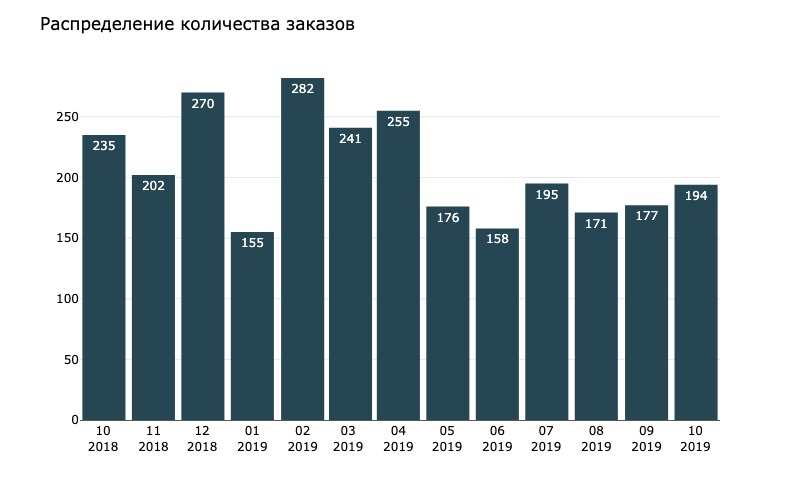

In [32]:
# создаем фигуру
fig = px.histogram(
    data_frame=orders,
    x='date',
    color_discrete_sequence=colors,
    width=800,
    nbins=orders['date'].nunique(),
    text_auto=True
)

# наводим красоту
style_plot(
    title='Распределение количества заказов'
)

# установим отступы между столбцами и формат подписей к оси х
fig.update_layout(
    bargap=0.1,
    xaxis_tickformat = '%m<br>%Y',
)

# сделаем подписи к каждому столбцу
fig.update_xaxes(
    tickvals=sorted(orders['date'].unique())
)

# выводим график
fig.show()

* Больше всего покупок совершается в период с февраля по апрель. Скорее всего это связано с подготовкой к дачному сезону,
* Пик заказов приходится на февраль,
* В декабре, также высокое количество заказов,
* А вот с мая по октябрь заказов относительно немного.

Теперь посмотрим на суммы этих заказов:

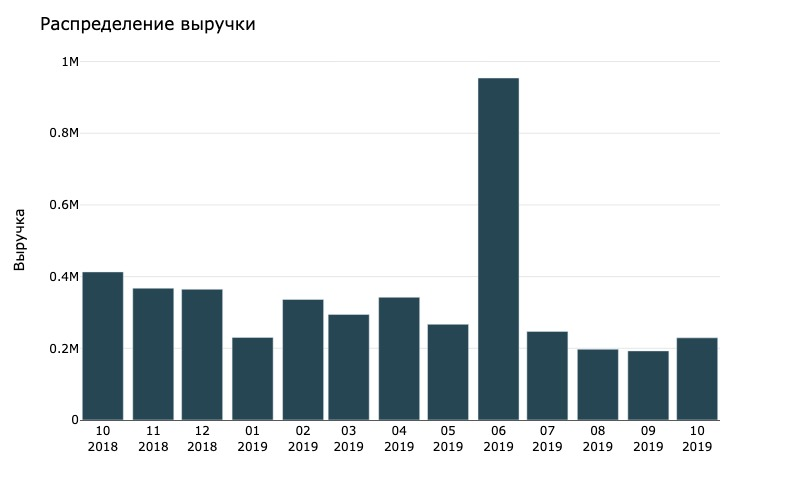

In [33]:
to_plot = orders.groupby('date').agg({'total': 'sum'}).reset_index()

# создаем фигуру
fig = px.bar(
    data_frame=to_plot,
    x='date',
    y='total',
    color_discrete_sequence=colors,
    width=800,
)

# наводим красоту
style_plot(
    title='Распределение выручки',
    ylabel='Выручка'
)

# установим отступы между столбцами и формат подписей к оси х
fig.update_layout(
    bargap=0.1,
    xaxis_tickformat = '%m<br>%Y',
)

# сделаем подписи к каждому столбцу
fig.update_xaxes(
    tickvals=sorted(orders['date'].unique())
)

# выводим график
fig.show()

В июне виден аномально большой пик. Посмотрим на самые большие заказы в этом месяце:

In [34]:
orders.query('date == "2019-06"').sort_values(by='quantity', ascending=False).head(10)

,order_id,date,quantity,total
1985,71743,2019-06,1000,675000.0
1948,71668,2019-06,334,49432.0
218,14835,2019-06,224,23660.0
2010,71802,2019-06,40,1520.0
1927,71623,2019-06,40,8080.0
238,14863,2019-06,39,7356.0
230,14848,2019-06,30,3970.0
1999,71770,2019-06,25,1275.0
227,14845,2019-06,24,2180.0
223,14841,2019-06,22,3620.0


Аномально высокое значение в июне обеспечено по большей части заказом 71743. Посмотрим, что было в этом заказе:

In [35]:
# выведем заказ на экран
data.query('order_id == 71743')

,date,customer_id,order_id,product,quantity,price,total,category
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,675000.0,другое


Кто-то купил тысячу вантузов на 675 000 рублей. Интересная жизнь у человека. Ну а если серьезно, то это скорее всего оптовый покупатель. Зафиксируем, что у нас присутствуют оптовые покупатели. Выделим оптовые заказы. Будем считать таковыми те, в которых более 100 единиц товара:

In [36]:
# выделим оптовые заказы
orders['is_wholesale'] = orders.apply(lambda x: True if x['quantity'] >= 100 else False, axis=1)

print('Всего оптовых заказов:', orders['is_wholesale'].sum())

Всего оптовых заказов: 15


У нас получилось 15 заказов, в которых более 100 единиц товаров. Опять построим распределение по заказам в месяц, но без учета оптовых заказов:

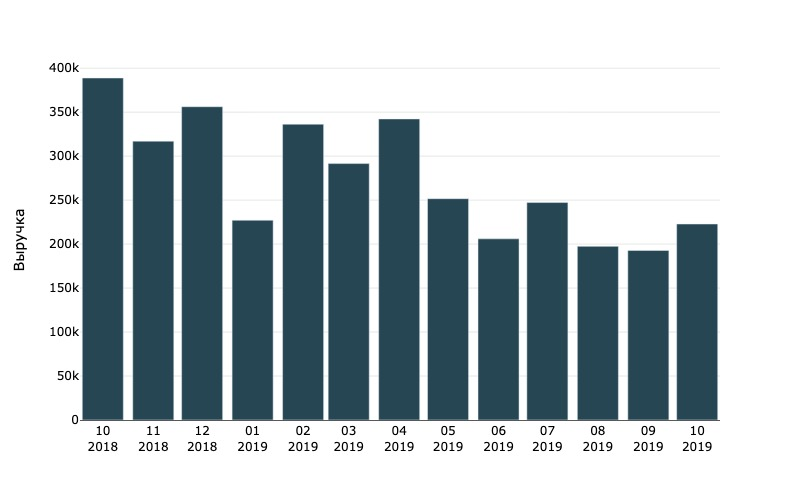

In [37]:
to_plot = orders.query('quantity < 100').groupby('date').agg({'total': 'sum'}).reset_index()

# создаем фигуру
fig = px.bar(
    data_frame=to_plot,
    x='date',
    y='total',
    color_discrete_sequence=colors,
    width=800,
)

# наводим красоту
style_plot(
    # title='Распределение выручки с неоптовых заказов',
    ylabel='Выручка'
)

# установим отступы между столбцами и формат подписей к оси х
fig.update_layout(
    bargap=0.1,
    xaxis_tickformat = '%m<br>%Y',
)

# сделаем подписи к каждому столбцу
fig.update_xaxes(
    tickvals=sorted(orders['date'].unique())
)

# выводим график
fig.show()

Теперь ситуация выглядит иначе:
* Возможно есть тренд на снижение выручки. Это можно заметить по разнице между октябрем 2018 и 2019 года. Но рано делать выводы, так как причина может быть в том, что пока не все данные дошли. Но зафиксируем этот момент.
* Больше всего выручки с декабря по апрель, с естественной просадкой в январе. Летом выручка стабильно на относительно низком уровне.

Посмотрим, что там с оптовыми заказами:

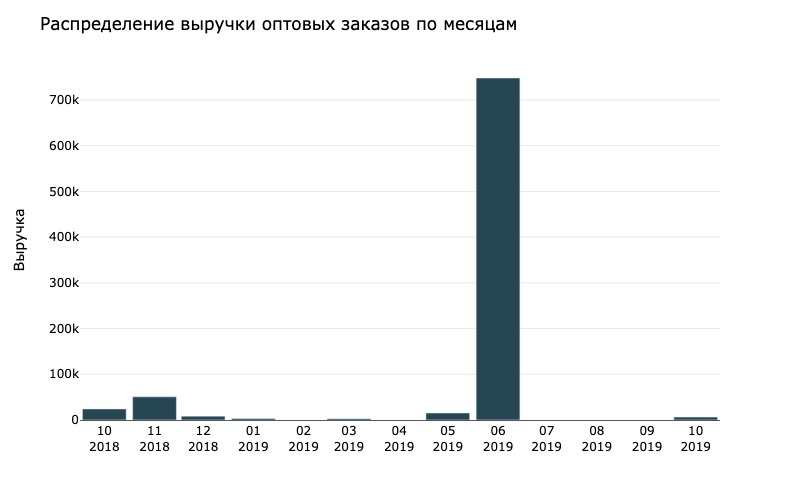

In [38]:
to_plot = orders.query('quantity >= 100').groupby('date').agg({'total': 'sum'}).reset_index()

# создаем фигуру
fig = px.bar(
    data_frame=to_plot,
    x='date',
    y='total',
    color_discrete_sequence=colors,
    width=800,
)

# наводим красоту
style_plot(
    title='Распределение выручки оптовых заказов по месяцам',
    ylabel='Выручка'
)

# установим отступы между столбцами и формат подписей к оси х
fig.update_layout(
    bargap=0.1,
    xaxis_tickformat = '%m<br>%Y',
)

# сделаем подписи к каждому столбцу
fig.update_xaxes(
    tickvals=sorted(orders['date'].unique())
)

# выводим график
fig.show()

В магазине был лишь один месяц с высокими оптовыми заказами – июнь 2019 года. В этот месяц магазин заработал на оптовых продажах почти 750 000 рублей. В остальные же месяцы оптовые заказы либо отсутствуют, либо не превышают 50 000 рублей.

Посмотрим как менялся средний чек по месяцам без учета оптовых заказов:

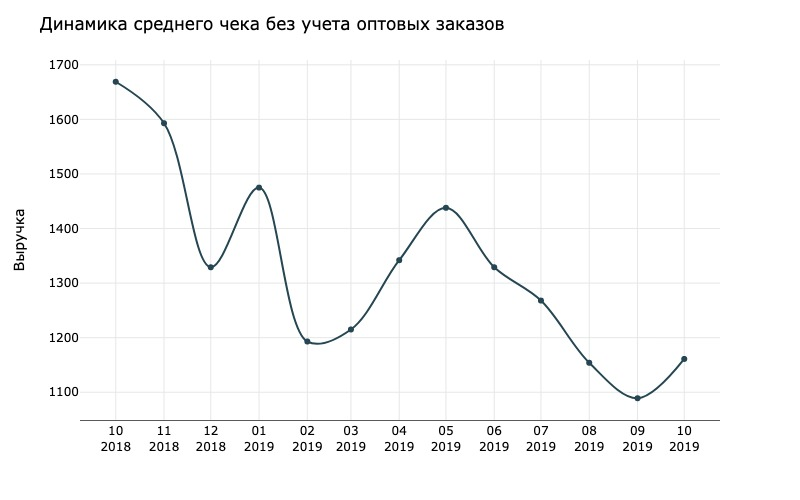

In [39]:
to_plot = orders.query('quantity < 100').groupby('date').agg({'total': 'mean'}).round().reset_index()

# создаем фигуру
fig = px.line(
    data_frame=to_plot,
    x='date',
    y='total',
    color_discrete_sequence=colors,
    width=800,
    markers=True
)

# наводим красоту
style_plot(
    title='Динамика среднего чека без учета оптовых заказов',
    ylabel='Выручка'
)

# установим формат подписей к оси х
fig.update_layout(
    xaxis_tickformat = '%m<br>%Y',
)

# сделаем подписи к каждому столбцу
fig.update_xaxes(
    tickvals=sorted(orders['date'].unique()),
    gridcolor='#E6E7E8'
)

#  сделаем линию более гладкой
fig.update_traces(
    line_shape='spline'
)

# выводим график
fig.show()

По графику виден тренд на снижение среднего чека. В октябре 2018 средний чек был около 1650 руб., а в октябре 2019 года средний чек составлял уже примерно 1150 руб. В течение исследуемого периода рост среднего чека наблюдался по мере приблежения дачного сезона – с марта по май. 

## Исследование категорий

Посмотрим на распределение товаров по категориям:

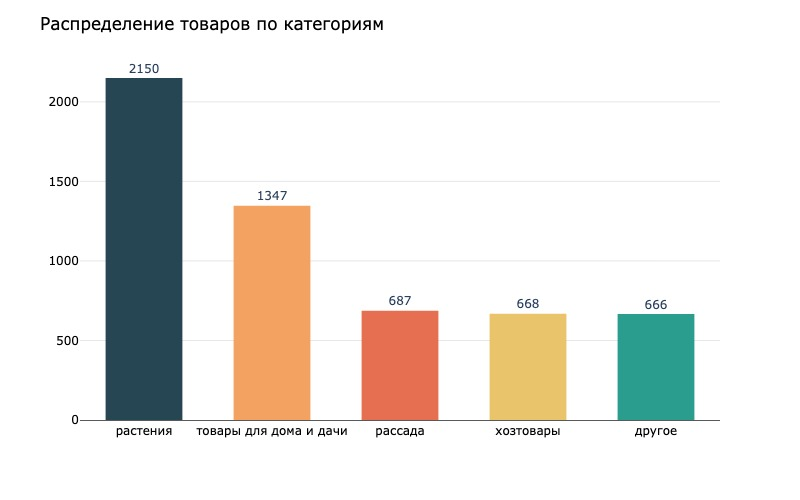

In [40]:
# строим фигуру
fig = px.histogram(
    data_frame=data,
    x='category',
    width=800,
    color_discrete_map={ # каждой категории выделяем свой цвет
        'растения': colors[0],
        'другое': colors[1],
        'хозтовары': colors[2],
        'товары для дома и дачи': colors[3],
        'рассада': colors[4]
    },
    color='category',
    text_auto=True
)

style_plot(
    title='Распределение товаров по категориям'
)

# убираем легенду и делаем отступы между столбцами
fig.update_layout(
    showlegend=False,
    bargap=0.4
)

# подписи со значениями выносим за столбцы
fig.update_traces(
    textposition='outside'
)

fig.show()

Больше всего товаров находятся в категории "растения". А вот категории "рассада", "другое" и "хозтовары" самые немногочисленные, в них более чем в 3 раза меньше товаров чем в "растениях".

Посмотрим на распределение покупок по категориям по времени:

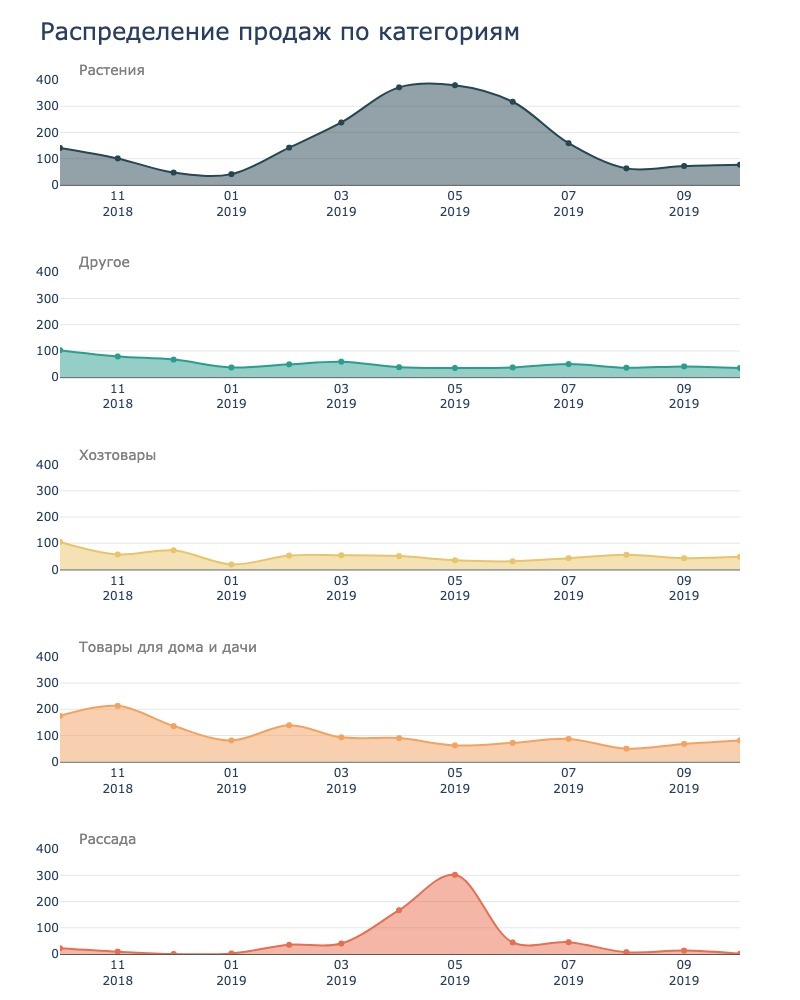

In [41]:
# готовим данные для визуализации
to_plot = data.copy()

# изменим формат даты
to_plot['date'] = to_plot['date'].apply(lambda x: x.strftime('%Y-%m'))

# создадим сводную таблицу
to_plot = to_plot.pivot_table(
    index='date',
    columns='category',
    values='product',
    aggfunc='count'
).reset_index().fillna(0)

# создаем фигуру
fig = make_subplots(
    rows=5,
    cols=1, 
    subplot_titles=[i.capitalize() for i in data['category'].unique()], 
    vertical_spacing=0.1
)

# добавим линии на график
for i, cat in enumerate(data['category'].unique()):
    fig.add_trace(go.Scatter(
        x=to_plot['date'],
        y=to_plot[cat],
        name=cat, 
        mode='lines+markers', 
        fillcolor=colors_rgba[i],
        line_color=colors[i],
        # opacity=0.1
        ),
        row=i+1, col=1)
    fig.layout.annotations[i].update(x=0.025, xanchor='left', font={'size': 14, 'color': 'grey'})

# наводим красоту
fig.update_layout(
    width=800, 
    height=1000, 
    showlegend=False, # убиарем легенду
    margin=dict(l=60, r=60, t=80, b=40), # настроим отступы
    plot_bgcolor='white', # цвет фона графика
    title='Распределение продаж по категориям',
    title_font_size=24 # размер шрифта
)

fig.update_xaxes(
    tickformat = '%m<br>%Y', # формат подписей к оси Х
    showline=True,
    linecolor='#58595B',
)

fig.update_yaxes(
    gridcolor='#E6E7E8',
    range = [0, 400] # диапазон значений оси y
)

fig.update_traces(
    line_shape='spline', # сглаженная линия
    fill='tozeroy' # заливка
)

fig.show()

В некоторых категориях присутствует сезонность:
* В категории "растения" наибольшие продажи в период с февраля по июль,
* В категории "рассада" продажи резко растут в апреле и мае,

В остальных категориях нельзя выделить четкий сезон.

Посмотрим на распределение средних цен по категориям:

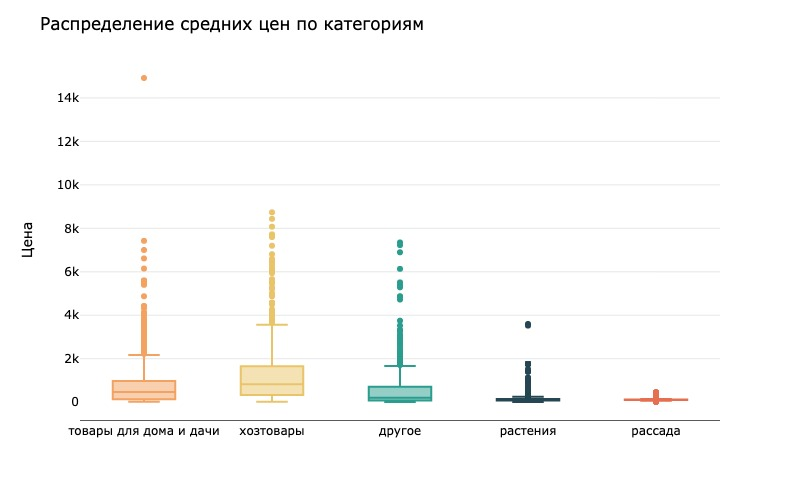

In [42]:
# создаем фигуру
fig = px.box(
    data_frame=data,
    x='category',
    y='price',
    color='category',
    color_discrete_map={ # каждой категории выделяем свой цвет
        'растения': colors[0],
        'другое': colors[1],
        'хозтовары': colors[2],
        'товары для дома и дачи': colors[3],
        'рассада': colors[4]
    },
    width=800
)

# наводим красоту
style_plot(
    title='Распределение средних цен по категориям',
    ylabel='Цена'
)

# убираем легенды
fig.update_layout(
    showlegend=False
)

fig.show()

* Самый дорогой товар находится в категории "товары для дома и дачи",
* Самая большая средняя цена и самый широкий диапазон цен в категории "хозтовары"
* Категория "рассада" характеризуется кучностью цен, и самой низкой средней ценой,
* Во всех категориях кроме "рассады" присутствуют выбросы – отдельные товары гораздо дороже основной группы.

Количество проданных товаров по категориям посмотрели, средние цены посмотрели, теперь посмотрим на структуру выручки по категориям. Сначала выведем общие доли выручки категорий за весь период исследования, без учета оптовых заказов, потому что они сильно исказят картину:

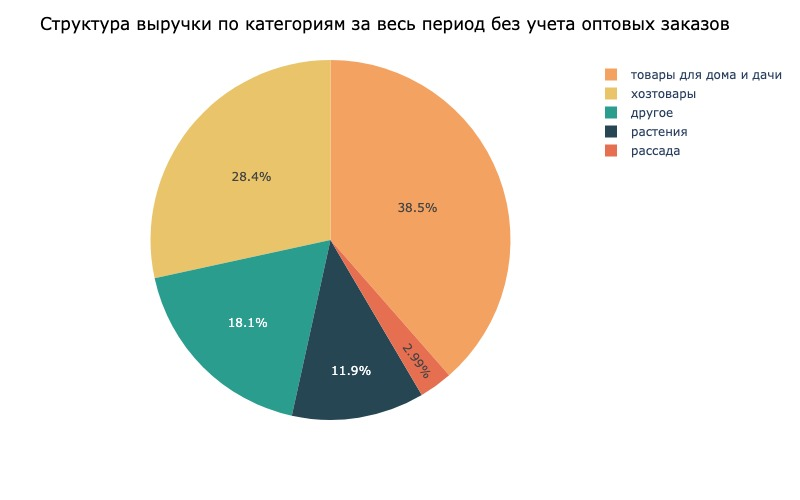

In [43]:
# готовим данные для визуализации
to_plot = data.query('quantity < 100').groupby('category').agg({'total': 'sum'})

to_plot['total'] = to_plot['total'] / to_plot['total'].sum()
to_plot = to_plot.reset_index()

# строим фигуру
fig = px.pie(
    data_frame=to_plot,
    values='total',
    names='category',
    color='category',
    color_discrete_map={
        'растения': colors[0],
        'другое': colors[1],
        'хозтовары': colors[2],
        'товары для дома и дачи': colors[3],
        'рассада': colors[4]
    },
    width=800
)

# наводим красоту 
style_plot(
    title='Структура выручки по категориям за весь период без учета оптовых заказов'
)

# выводим фигуру
fig.show()

Более чем две трети выручки делают категории "товары для дома и дачи" и "хозтовары". Самая низкая доля в категории "рассада". 

Теперь посмотрим структуру выручки по каждому месяцу:

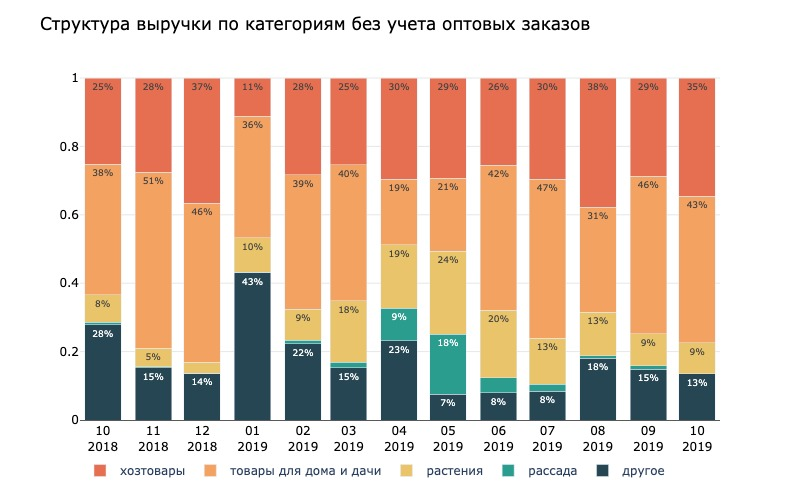

In [44]:
# готовим данные для визуализации
to_plot = data.copy()
to_plot = to_plot.query('quantity < 100')

# форматируем дату
to_plot['date'] = to_plot['date'].apply(lambda x: x.strftime('%Y-%m'))

# делаем сводную таблицу
to_plot = to_plot.pivot_table(
    index='date',
    columns='category',
    values='total',
    aggfunc='sum'
).fillna(0)

# делаем относительные значения вместо абсолютных
to_plot_total = to_plot.sum(axis=1)
for col in to_plot.columns:
    to_plot[col] = to_plot[col] / to_plot_total

to_plot = to_plot.reset_index()

# строим фигуру
fig = go.Figure()

# добавляем столбцы
for i, cat in enumerate(to_plot.columns[1:]):
    fig.add_trace(go.Bar(
        x=to_plot['date'],
        y=to_plot[cat],
        name=cat,
        marker_color=colors[i],
        text=to_plot[cat],
        texttemplate='%{y:.0%}', # формат отображения текста в процентах
        textposition='inside',
        textfont_size=9 # размер шрифта
    )) 

# наводим красоту
style_plot(
    title='Структура выручки по категориям без учета оптовых заказов'
)

fig.update_layout(
    barmode='stack', # стобцы стоят друг на дружке
    legend_orientation='h',
    height=500,
    width=800,
    uniformtext_minsize=9, # минимальный размер текста
    uniformtext_mode='hide', # если столбец слишком мал, то скрываем подпись
    margin_t=60
)

fig.update_xaxes(
    tickformat = '%m<br>%Y', # формат подписей к оси Х 
    tickvals=sorted(to_plot['date'].unique()), # подписи к оси Х
)

# выводим график
fig.show()

* Стабильно высокая доля выручки приходится на категорию "товары для дома и дачи". В ноябре 2018 года на эту категорию приходилось 54% выручки.
* В период с осени по весну подавляющая доля выручки идет с категорий "хозтовары" и "товары для дома и дачи".

## Общие выводы

Напомним, что мы делали исследовательский анализ данных на двух уровнях – на уровне заказов и на уровне категорий.

**Основные выводы при изучении заказов:**
* Больше всего покупок совершается с февраля по апрель. Это может быть связано с подготовкой к дачному сезону.
* Есть заказы оптовые и неоптовые. Оптовыми мы считали те заказы в которых более 100 единиц продукции. Всего таких заказов оказалось 15. Самый большой оптовый заказ был в июне 2019 года – на сумму 675 000 руб. 
* Выручка в зимний сезон выше, чем в летний. А в целом по данным виден тренд на снижение выручки. Так в октябре 2018 года она была около 388 000 руб., а в октябре 2019 она была около 222 000 руб. Конечно, возможно, что это связано с тем, что не все данные у нас дошли. Но на этот момент нужно обратить внимание.
* Средний чек, также, имеет тренд на понижение в октябре 2018 он был 1700 руб., а в октябре 2019 он составлял уже 1150 руб. Рост среднего чека был виден в период подготовки к дачному сезону – в феврале 2019 года он был равен 1200 руб., а в мае вышел на локальный пик в 1450 руб. После этого он только снижался.

**Основыне выводы при изучении категорий:**
* Больше всего товаров попадает в категорию "растения" – 2150 шт. Самые немногочисленные категории – "рассада", "хозтовары" и другое. В каждой из них около 680 единиц продукции.
* Некоторые категории имеют сезонность:
    * растения покапают чаще в период с февраля по июнь,
    * сезон для категории рассада это апрель-май
* Самый дорогой товар находится в категории "товары для дома и дачи". Самый высокий порядок цен в категории "хозтовары". "Рассада" характеризуется кучностью цен и самой низкой средней ценой. Для всех категорий, кроме рассады, характерно наличие выбросов – товаров, которые стоят сильно больше чем основная масса.
* За исследуемый период больше всего выручки принесли 2 категории: "товары для дома и дачи" и хозтовары". На них пришлось почти две трети выручки. Самая маленькая выручка оказалась у категории "рассада".
* В период с осени по весгну подавляющая доля выручки идет с категорий "хозтовары" и "товары для дома и дачи".

# Проверка гипотезы об основных и дополнительных категориях

Одна из целей нашего исследования – определить категории, которые являются основными, а какие являются дополнительными. Будем считать критерием основной категории – высокую среднюю выручку. После исследовательского анализа данных мы выяснили, что самые емкие по выручке категории – "товары для дома и дачи" и "хозтовары". При проверке гипотезы будем считать что это и есть основные категории. А остальные определим как дополнительные.

Итак формулируем статистичекие гипотезы:
* **Нулевая гипотеза**: средняя выручка в категориях "товары для дома и дачи" и "хозтовары" статистически не отличается от выручки в других категориях
* **Альтернативная гипотеза**: средняя выручка в категориях "товары для дома и дачи" и "хозтовары" отличается от остальных категорий.
 
Уровень значимости зададим 0,05.

In [45]:
# задаем уровень значимости
alpha = 0.05

Создадим для каждой категории свою переменную. Также уберем оптовые заказы, так как их мало и они испортят наше распределение:

In [46]:
# срез данных с основными категориями
main_cat = data[
    (data['category'].isin(['товары для дома и дачи', 'хозтовары']) 
    & (data['quantity'] < 100))
].copy()

# срез данных с дополнительными категориями
additional_cat = data[
    ~(data['category'].isin(['товары для дома и дачи', 'хозтовары']))
    & (data['quantity'] < 100)
].copy()

Посмотрим на распределение выручки от заказа в созданных категориях:

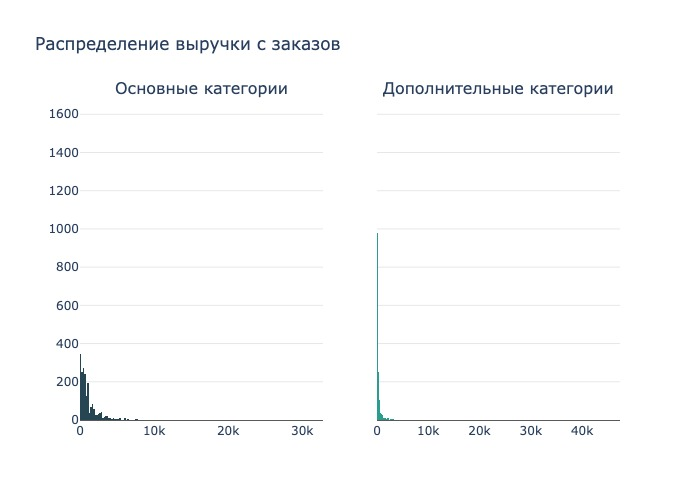

In [47]:
# cоздадим фигуру
fig = make_subplots(
    rows=1,
    cols=2,
    shared_yaxes=True,
    subplot_titles=('Основные категории', 'Дополнительные категории')
)

# добавим графики
for i, df in enumerate([main_cat, additional_cat]):
    fig.add_trace(
        go.Histogram(
            x=df['total'],
            marker_color=colors[i]
        ),
        row=1,
        col=i+1
    )

# уберем легенду, поменяем цвет фона, задаем заголовок
fig.update_layout(
    plot_bgcolor='white', # цвет фона графика
    showlegend=False,
    title='Распределение выручки с заказов'
)

# настроим цвет сетки по оси y
fig.update_yaxes(
    gridcolor='#E6E7E8',
)

# настроим цвет сетки по оси x
fig.update_xaxes(
    showline=True,
    linecolor='#58595B',
)

fig.show()

Чтобы статистический тест работал корректно, нам нужно избавиться от выбросов. А на графике видно, что есть довольно таки сильные выбросы. Сделаем срез по 95 перцентилю в обоих выборках:

In [48]:
# делаем срез по 95 перцентилю, чтобы убрать выбросы
main_cat_upd = main_cat[main_cat['total'] < np.percentile(main_cat['total'], 95)]
additional_cat_upd = additional_cat[additional_cat['total'] < np.percentile(additional_cat['total'], 95)]

Посмотрим как теперь выглядят распределения:

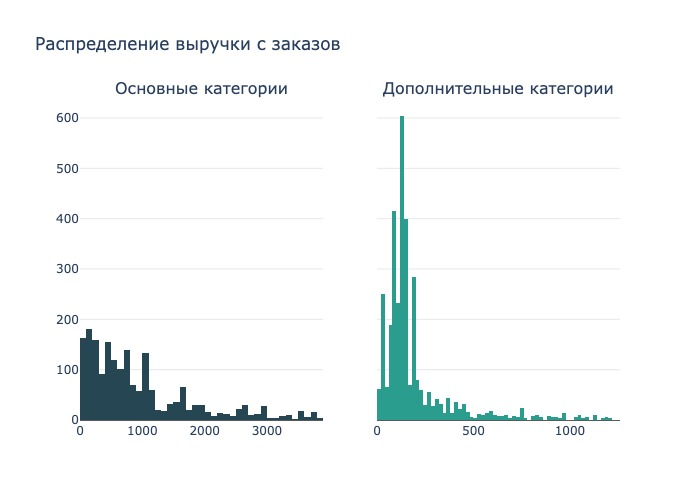

In [49]:
# cоздадим фигуру
fig = make_subplots(
    rows=1,
    cols=2,
    shared_xaxes=True,
    shared_yaxes=True,

    subplot_titles=('Основные категории', 'Дополнительные категории')
)

# добавим графики
for i, df in enumerate([main_cat_upd, additional_cat_upd]):
    fig.add_trace(
        go.Histogram(
            x=df['total'],
            marker_color=colors[i]
        ),
        row=1,
        col=i+1
    )

# уберем легенду, поменяем цвет фона, задаем заголовок
fig.update_layout(
    plot_bgcolor='white', # цвет фона графика
    showlegend=False,
    title='Распределение выручки с заказов'
)

# настроим цвет сетки по оси y
fig.update_yaxes(
    gridcolor='#E6E7E8',
)

# настроим цвет сетки по оси x
fig.update_xaxes(
    showline=True,
    linecolor='#58595B',
)

fig.show()

Распределения все еще не сильно напоминают нормальное, хотя в дополнительных категориях некоторые сходства есть. Выбросы в категориях все еще присутствуют, но мы и так убрали слишком много значений. Оставим текущие данные как есть. 

Так как мы сравниваем средние двух выборок, то будем использовать тест Стьюдента для двух независимых выборок. У нас есть предпосылки к тому, что дисперсия в генеральных совокупностях может быть разная, поэтому в параметре `equal_var` поставим значение `True`.

In [50]:
# проводим тест
result = st.ttest_ind(
    main_cat_upd['total'],
    additional_cat_upd['total'],
    equal_var=False
).pvalue

# делаем выводы
print(f'p-value: {result}')
if result < alpha:
    print('Отвергаем нулевую гипотезу: средняя выручка от товаров основной категории выше, чем в дополнительной')
else:
    print('Не достаточно оснований отвергнуть нулевую гипотезу')


p-value: 5.811296512901347e-230
Отвергаем нулевую гипотезу: средняя выручка от товаров основной категории выше, чем в дополнительной


Статистический тест показал, что средняя выручка по товарам из основных категорий действительно выше, чем в дополнительных.

# Общие выводы
Напомним вводные:

**Задача**: провести категоризацию товаров и определить основные и дополнительные категории.

**Период исследования**: с октября 2018 по октябрь 2019 (включительно).

**Описание данных**: Датасет описывает транзакции интернет-магазина товаров для дома и быта "Пока все еще тут"

## Категоризация товаров

Среди товаров мы обнаружили 5 категорий: 
* растения,
* рассада,
* хозтовары,
* товары для дома и дачи,
* другое

Характеристики категорий:
1. **Растения**:
    * 2150 товаров попадают в эту категорию, это самая большая категория,
    * эта категория имеет сезонность: с февраля по июль.
    * цены за единицу товара довольно кучны, и относительно низки, по сравнению с другими категориями,
    * всего на эту категорию приходится около 12% выручки за исследуемый период
2. **Рассада**:
    * 687 товаров покали в эту категорию,
    * эта категория имеет сезонность: апрель-май.
    * все цены на товары кучные и средняя цена за единицу товара самая низкая среди остальных категорий,
    * 3% – доля категории "рассада" по выручке за весь период исследования,
3. **Хозтовары**:
    * 668 товаров попадают под эту категорию,
    * У этой категории нет сезонности: товары продаются стабильно весь год,
    * В категории "хозтовары" самая высокая средняя цена, и в целом диапазон цен самый широкий,
    * Это вторая по выручке категория: 28,4% выручки за исследуемый период пришло за период исследования
4. **Товары для дома и дачи**:
    * 1347 товаров содержит эта категория,
    * В 2018 году товары из этой категории продавались лучше чем в 2019. А в целом по году продажи ровные,
    * В этой категории находится самый дорогой товар – цена около 15 000 руб.
    * Это самая емкая по выручке категория: на нее приходится 38,5% от всей выручки за период исследования
5. **Другое**:
    * Самая маленькая категория по количеству товаров: 666 единиц товара,
    * Продажи по всему городу стабильные,
    * В этой категории содержится самый дорогой заказ – на 675 000 руб.,
    * 18,1% доля этой категории в общей выручки.

## Основные и дополнительные категории

Мы решили, что критерием основной категории будет средняя выручка с товара. По этому критерию подходили 2 категории: "товары для дома и дачи" и "хозтовары". Остальные категории мы отнесли к дополнительным. 

Мы сформировали следующие статические гипотезы:
* **Нулевая гипотеза**: средняя выручка в категориях "товары для дома и дачи" и "хозтовары" статистически не отличается от выручки в других категориях
* **Альтернативная гипотеза**: средняя выручка в категориях "товары для дома и дачи" и "хозтовары" отличается от остальных категорий.

Для проверки гипотезы мы использовали т-тест Стъюдента для двух выборок. Уровень значимости мы установили 0,05. 

P-value оказался гораздо ниже уровня значимости поэтому мы приняли альтернативную гипотезу. То есть основные наши товары лежат в категориях "товары для дома и дачи" и "хозтовары". А дополнительные в остальных категориях.